In [9]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf


# RNN uses previous 50 close prices to predict the average over the next 5 close prices.
previous_timesteps = 60

def import_csv(filename):
    df = pd.read_csv(filename)
    selected_columns = ['Open time', 'Close']
    df = df[selected_columns]
    return df

def generate_rolling_averages(df):
    df['15_unit_avg'] = df['Close'].rolling(window=15).mean()
    df['60_unit_avg'] = df['Close'].rolling(window=60).mean()
    df['1440_unit_avg'] = df['Close'].rolling(window=1440).mean()
    df['10080_unit_avg'] = df['Close'].rolling(window=10080).mean()
    return df

def generate_numpy_array(df, timefrom, timeto):

    # We take the df provided and give a numpy array with shape (dflength, 50, 6)
    # Df Length is the length of the dataframe, and the 50 is the 50 entries before
    # 1st column in the df is the time and the next 5 are the close + rolling averages.

    # Find index of time from and time to
    timefrom = pd.to_datetime(timefrom)
    timeto = pd.to_datetime(timeto)
    # convert to unix time milliseconds
    timefrom = timefrom.timestamp() * 1000
    timeto = timeto.timestamp() * 1000

    timefrom_index = df[df['Open time'] == timefrom].index[0]
    timeto_index = df[df['Open time'] == timeto].index[0]

    print (timefrom)
    print (timeto)

    # Assuming df is your DataFrame and it has 6 columns
    dfLength = len(df[timefrom_index:timeto_index])

    # Initialize the 3D array
    array_3d = np.zeros((dfLength, 60, 6))

    # Fill the 3D array
    for i in range(timefrom_index, timeto_index):
        # Determine the start index for slicing the DataFrame, ensuring it's not negative
        start_idx = max(i - 59, 0)
        # Slice the DataFrame to get up to 50 rows ending with the current row
        temp_df = df.iloc[start_idx:i+1]
        #print(temp_df)
        # If there are fewer than 50 rows, pad the beginning with zeros
        if len(temp_df) < 60:
            # padding = np.zeros((50 - len(temp_df), 6))
            # temp_array = np.vstack((padding, temp_df.to_numpy()))
            pass
        else:
            temp_array = temp_df.to_numpy()
            # Assign this 2D array to the corresponding "page" in the 3D array
            array_3d[i-timefrom_index, :, :] = temp_array
    return array_3d

def remove_time(numpy_array):
    return numpy_array[:, :, 1:]

def normalise_numpy_array(array_3d, fulldataframe):
    for i in range(5):
        min_val = fulldataframe.iloc[:, i + 1].min()
        max_val = fulldataframe.iloc[:, i + 1].max()
        array_3d[:, :, i] = (array_3d[:, :, i] - min_val) / (max_val - min_val)
    return array_3d

def fit_to_model(array_2d, model):
    # 2D array is the array of the last 50 close prices
    # We need to fit this to the model and get the prediction

    #array_2d = array_2d.reshape(-1, previous_timesteps, 5)
    # print(array_2d)
    # print(array_2d.shape)
    prediction = model.predict(array_2d)
    return prediction

def check_prediction(current, prediction, position, meanPrevious, stdPrevious):
    # Get percentage difference between current and prediction
    percentage_difference = prediction - current

    # If percentage difference is greater than 0.002, return buy
    # Else return close
    if percentage_difference > meanPrevious + stdPrevious*1.5:
        if position == 'buy' or position == 'hold':
            return 'hold'
        else:
            return 'buy'
    elif percentage_difference < meanPrevious - stdPrevious*0.8:
        if position == 'buy' or position == 'hold':
            return 'close'
        else:
            return 'nothing'
    else:
        if position == 'buy'  or position == 'hold':
            return 'hold'
        return 'nothing'
    
def check_ROI(array_3d):
    currententry = 0
    currentROI = 0
    position = 'close'
    for i in range(array_3d.shape[0]):
        prediction = check_prediction(array_3d[i, 0, 0], array_3d[i, 0, 5], position)
        if prediction == 'buy':
            position = 'buy'
            currententry = array_3d[i, 0, 0]
        elif prediction == 'close':
            if position == 'buy':
                position = 'close'
                currentROI += (array_3d[i, 0, 0] - currententry) / currententry + currentROI * (array_3d[i, 0, 0] - currententry) / currententry
    return currentROI
     

In [10]:
   
    
# Import BTCUSDT.h5 current folder.
# print tensorflow version
print(tf.__version__)
#model = tf.keras.models.load_model('BTCUSDT.h5')
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,losses

x_length = 5
seq_length = 60

model = tf.keras.models.load_model('BTCUSD_close_60p_5m_rolling_v2.keras')

#Import the CSV file
df = import_csv('BTCUSDT.csv')

# Generate rolling averages
df = generate_rolling_averages(df)

# Generate numpy array
array_3d = generate_numpy_array(df, '2023-01-01 00:00:00', '2023-01-02 00:00:00')

#print (array_3d)
#Remove time from numpy array
array_3dn = remove_time(array_3d)

# # Normalise the numpy array
array_3dn = normalise_numpy_array(array_3dn, df)

# # starting_cost = 100
prediction_array = np.pad(array_3dn, ((0, 0), (0, 0), (0, 1)), mode='constant')

# #Fit the model for our chosen sample.
#for i in range(array_3dn.shape[0]):
    # the prediction
# only take the first of each array
# new = array_3dn[:,:,0]
# print(new.shape)
prediction = fit_to_model(array_3dn, model)
prediction_array[:, :, 5] = prediction

2.16.2
1672531200000.0
1672617600000.0
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [63]:
print(prediction_array[:,0,0])
print(prediction_array[:,0,5])

[0.39752988 0.39765091 0.39728435 ... 0.39927852 0.39993639 0.40050194]
[0.39906302 0.39907998 0.39909866 ... 0.40441909 0.40443808 0.40446898]


In [20]:
print(prediction_array)
print(prediction)

[[[0.39647145 0.3974183  0.39864164 0.39861849 0.3765392  0.39519808]
  [0.39706193 0.39761181 0.39862398 0.39863703 0.37654815 0.39519808]
  [0.39670746 0.39767688 0.39858236 0.39864349 0.37655707 0.39519808]
  ...
  [0.39446187 0.39614593 0.39668708 0.39724716 0.37694248 0.39519808]
  [0.39446127 0.3959814  0.39664352 0.3972022  0.3769508  0.39519808]
  [0.39503589 0.39592664 0.39663263 0.39717725 0.37695926 0.39519808]]

 [[0.39706193 0.39761181 0.39862398 0.39863703 0.37654815 0.39588583]
  [0.39670746 0.39767688 0.39858236 0.39864349 0.37655707 0.39588583]
  [0.3966913  0.39773137 0.3985504  0.39864365 0.37656599 0.39588583]
  ...
  [0.39446127 0.3959814  0.39664352 0.3972022  0.3769508  0.39588583]
  [0.39503589 0.39592664 0.39663263 0.39717725 0.37695926 0.39588583]
  [0.39576492 0.39603231 0.3966567  0.39718033 0.37696778 0.39588583]]

 [[0.39670746 0.39767688 0.39858236 0.39864349 0.37655707 0.39560091]
  [0.3966913  0.39773137 0.3985504  0.39864365 0.37656599 0.39560091]
  [0

In [11]:
import numpy as np

x = array_3dn.shape[0]
reshaped_array = np.reshape(prediction_array[:, -1, :], (x, 6))

df = pd.DataFrame(reshaped_array)

In [12]:
# iterate through each row in df and check prediction
# add column

batch_size = 1440
num_batches = len(df) // batch_size

batches = [df[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]

prevbatchmean = -0.0068
prevbatchstd = 0.004

# rolling mean and std
rollingmean = df[:,5].rolling(window=123).mean()

for batch in batches:
    batch['Action'] = 'hold'
    prediction = 'close'
    for i in range(batch.shape[0]):
        batch.iloc[i, 6] = check_prediction(batch.iloc[i, 0], batch.iloc[i, 5], prediction, prevbatchmean, prevbatchstd)
        prediction = batch.iloc[i, 6]

    prevbatchmean = np.mean((batch.iloc[:, 5] - batch.iloc[:, 0]))
    prevbatchstd = np.std((batch.iloc[:, 5] - batch.iloc[:, 0]))

    
# Now append batchs
df = pd.concat(batches)

print (df)

             0         1         2         3         4         5   Action
0     0.207405  0.208024  0.207484  0.207716  0.215247  0.205816  nothing
1     0.207405  0.208022  0.207494  0.207715  0.215247  0.205819  nothing
2     0.207339  0.208022  0.207501  0.207714  0.215247  0.205828  nothing
3     0.207295  0.208016  0.207508  0.207713  0.215246  0.205830  nothing
4     0.207253  0.208010  0.207515  0.207713  0.215246  0.205831  nothing
...        ...       ...       ...       ...       ...       ...      ...
1435  0.208404  0.209054  0.208745  0.207535  0.214652  0.206880  nothing
1436  0.208461  0.209057  0.208748  0.207536  0.214652  0.206886  nothing
1437  0.208555  0.209066  0.208752  0.207537  0.214651  0.206893  nothing
1438  0.208516  0.209073  0.208756  0.207538  0.214651  0.206897  nothing
1439  0.208503  0.209077  0.208760  0.207539  0.214651  0.206904  nothing

[1440 rows x 7 columns]


/tmp/ipykernel_11613/404290957.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['Action'] = 'hold'


0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1435   -0.007144
1436   -0.007160
1437   -0.007198
1438   -0.007225
1439   -0.007240
Length: 1440, dtype: float64


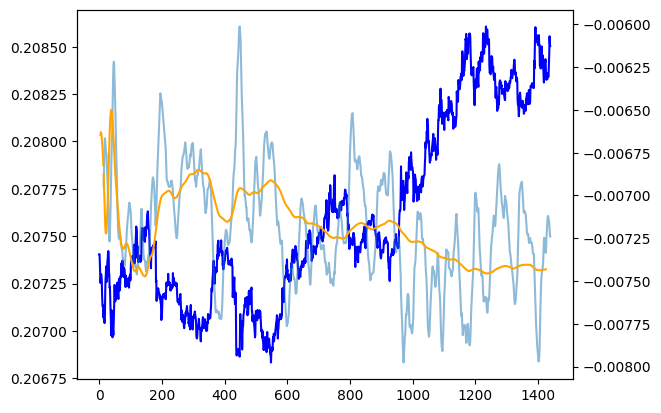

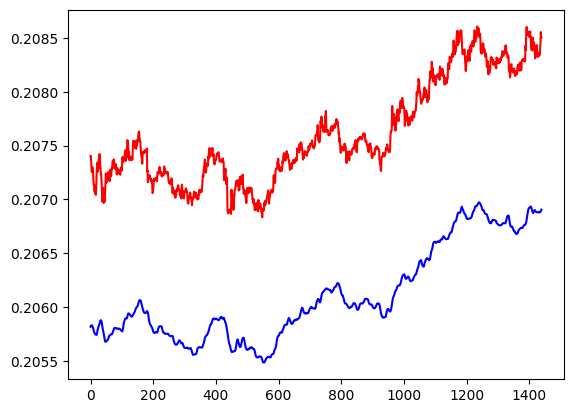

In [45]:
import matplotlib.pyplot as plt

def calculate_trendline(window_data):
    """
    Calculate slope and intercept for the given window of data.
    """
    x_values = np.arange(len(window_data))
    slope, intercept = np.polyfit(x_values, window_data, 1)
    return slope * x_values + intercept

# Get the stock prices
stock_prices = df.iloc[:,0]

# # Create the plot
# plt.plot(stock_prices)

fig, ax1 = plt.subplots() 

ax1.plot(stock_prices, color = 'blue')

# Add green dots for buy positions
buy_positions = df[df['Action'] == 'buy'].index
ax1.scatter(buy_positions, stock_prices[buy_positions], color='green', marker='o')

# Add red dots for sell positions
sell_positions = df[df['Action'] == 'close'].index
ax1.scatter(sell_positions, stock_prices[sell_positions], color='red', marker='o')

# Show the plot
#plt.show()

ax2 = ax1.twinx()

# Calculate the percentage difference between df 0 and df 5
percentage_diff =  (df.iloc[:, 5] - df.iloc[:, 0])/df.iloc[:, 0]

#calculate rolling mean 3 of percentage dif
percentage_diff = percentage_diff.rolling(window=15).mean()

droped_na = percentage_diff.dropna()

# Create the plot
ax2.plot(percentage_diff, alpha=0.5)

ax2.plot(droped_na.rolling(window=200).median(), color = 'red')

# Define window size for rolling calculation
window_size = 5



print(percentage_diff)
# Add green dots for buy positions
# buy_positions = df[df['Action'] == 'buy'].index
# plt.scatter(buy_positions, percentage_diff[buy_positions], color='green', marker='o')

# # Add red dots for sell positions
# sell_positions = df[df['Action'] == 'close'].index
# plt.scatter(sell_positions, percentage_diff[sell_positions], color='red', marker='o')

# Show the plot
plt.show()

plt.plot(df.iloc[:, 5], color = 'blue')
plt.plot(df.iloc[:, 0], color = 'red')

# # Add green dots for buy positions
# buy_positions = df[df['Action'] == 'buy'].index
# plt.scatter(buy_positions, df.iloc[buy_positions, 5], color='green', marker='o')

# # Add red dots for sell positions
# sell_positions = df[df['Action'] == 'close'].index
# plt.scatter(sell_positions, df.iloc[sell_positions, 5], color='red', marker='o')

# Show the plot
plt.show()



In [11]:
# get df between our times
# '2021-01-01 00:00:00', '2021-01-02 00:00:00'
# '2021-01-01 00:00:00', '2021-12-01 00:00:00'
# '2020-01-01 00:00:00', '2023-01-01 00:00:00'
timefrom = '2020-01-01 00:00:00'
timeto = '2023-01-01 00:00:00'
timefrom = pd.to_datetime(timefrom)
timeto = pd.to_datetime(timeto)
# convert to unix time milliseconds
timefrom = timefrom.timestamp() * 1000
timeto = timeto.timestamp() * 1000

print(timefrom)

# get the df in our time period
# reload from ccsv
df2 = import_csv('BTCUSDT.csv')
df2 = df2[(df2['Open time'] >= timefrom) & (df2['Open time'] < timeto)]
#rename df2 close column to closeprice
df2 = df2.rename(columns={'Close': 'Closeprice'})

df2 = df2.sort_values(by='Open time').reset_index(drop=True)

# get close and add to df
df['closeprice'] = df2['Closeprice']

# split the df into days

batch_size = 1440
num_batches = len(df) // batch_size

batches = [df[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]

profits = []

for batch in batches:
    profit = 0
    position = 1
    previous_buy = 0

    for index, row in batch.iterrows():
        if row['Action'] == 'buy':
            previous_buy = row['closeprice']
        elif row['Action'] == 'close':
            position = position + position * ((row['closeprice'] - previous_buy) / previous_buy)

    profits.append(position)

print(profits)
print(np.mean(profits))

1577836800000.0
[1, 0.9897520791056129, 1.009289595383237, 1.0108989578499978, 1.010280056336361, 1.013344555449877, 0.9963284339018987, 0.9963018327917362, 1.002377858270568, 1.0250443656012411, 1.0052209601623805, 1.0104179122646741, 1.021042687877754, 1.0271186817599154, 1.0245374430779546, 1.0007077899044945, 1.0071990383080351, 1.0190667129755235, 0.9784142609334089, 1, 1.017131469104818, 1.0125564261790083, 1.0031841929326468, 1.00267617018042, 0.9886371443984959, 1.0003456545302514, 1.019164131364776, 1.0055580457585243, 1.0142429741548162, 1.0165052849447003, 1.0102998421694038, 1.0115122400636525, 1.008253740656398, 0.994213611392655, 1.0053380243946732, 1.0179117579354, 1.01061790024369, 1.0164370314821047, 1.0168030679658768, 1.0151462124055026, 0.9886945664937259, 1.0013222177486276, 1.0231651100073185, 0.9898442091142642, 1.0136174050656832, 0.9957248908770905, 1.0011498249844155, 1.0164272264360912, 1.0104596713231244, 0.9762431226035267, 1.0087931624197772, 1.00690019858

In [79]:
#get df again
newnew = import_csv('BTCUSDT.csv')

#get max close price
maxclose = newnew['Close'].max()
minclose = newnew['Close'].min()

#array_3d[:, :, i] = (array_3d[:, :, i] - min_val) / (max_val - min_val)
print(maxclose)
print(minclose)

69000.0
2817.0
